# 大問2

## (1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

### 問題設定

Aは1000次とした。

bは1000次で各値は0から100までのfloat型の乱数を作成した。

乱数はseedをとって各手法で固定し た。

また、許容誤差は1 x 10^-10とした

In [2]:
# 次数の設定
degree = 1000

# x_k-1とx_kの差がtol未満なら収束したとみなす
tol = 1e-6

max_iter = 50000

In [3]:
# A: 本レポートではtridiagonal_matrix(2), tridiagonal_matrix(20)を用いる
def tridiagonal_matrix(c, n = degree):
    A = np.zeros([n, n])
    for i in range(n):
        if i == 0:
            A[i,i] = c 
            A[i, i+1] = -1
        elif i == n - 1:
            A[i, i - 1] = -1
            A[i, i] = c
        else:
            A[i, i - 1] = -1
            A[i, i] = c
            A[i, i + 1] = -1
    return A

# b
def constant_vector(n = degree):
    np.random.seed(23)  # 23は適当な数字
    return np.random.uniform(0.0, 100.0, [n, 1])

### 実装

逆行列は一度求めればその後掛け算するだけで使えるため、計算してしまっています

#### CG法

In [4]:
def cg(A, b = constant_vector()):
    xs = np.array([b])
    
    r = b - np.dot(A, xs[0])
    p = r
    
    k = 0
    error = 1
    
    while  error > tol:
        alpha = np.dot(r.T, p) / (p.T @ A @ p)
        xs = np.append(xs, [xs[k] + alpha * p], axis = 0)
        r = r - alpha * np.dot(A, p)
        beta = -1 * (r.T @ A @ p) / (p.T @ A @ p)
        p = r + beta * p
        error = np.linalg.norm(np.dot(A, xs[k+1] - b))
        k += 1
        
    print("CG法はk={}で収束しました。".format(k))
    return xs

#### Gauss-Seidel法 (c = 2 で収束しなかったので、上限を設けました)

In [5]:
def gs(A, b = constant_vector()):
    xs = np.array([b])
    
    LD_inv = np.linalg.inv(np.tril(A))
    U = np.triu(A, 1)
    
    H = -1 * np.dot(LD_inv, U)
    c = LD_inv @ b
    
    k = 0
    error = tol + 1
    
    while  error > tol:
        xs = np.append(xs, [np.dot(H, xs[k]) + c], axis = 0)
        error = np.linalg.norm(np.dot(A, xs[k+1] - b))
        k += 1
        if k > max_iter:
            print("Gauss-Seidel法は{}回の反復では収束しませんでした。".format(k))
            return xs

        
    print("Gauss-Seidel法はk={}で収束しました。".format(k))
    return xs

#### SOR法

In [6]:
def sor(A, b = constant_vector()):
    xs = np.array([b])

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L + U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    w = 2 / (1 + np.sqrt(1 - rho_Mj ** 2))

    T = np.linalg.inv(D + w * L)
    H = np.dot(T, -w * U + (1 - w) * D)
    c = np.dot(T, w * b)
    
    k = 0
    error = tol + 1

    while  error > tol:
        xs = np.append(xs, [np.dot(H, xs[k]) + c], axis = 0)
        error = np.linalg.norm(np.dot(A, xs[k+1] - b))
        k += 1
        
    print("SOR法はk={}で収束しました。".format(k))
    return xs

#### Jacobi法

c = 2で全く収束しなかったので、反復回数に上限を設けています。

In [7]:
def jacobi(A, b = constant_vector()):
    xs = np.array([b])
    
    D = np.diag(np.diag(A))
    LU = A - D
    D_inv = np.linalg.inv(D)
    
    H = -1 * np.dot(D_inv, LU)
    c = np.dot(D_inv, b)
    
    k = 0
    error = tol + 1
    
    while  error > tol:
        xs = np.append(xs, [np.dot(H, xs[k]) + c], axis = 0)
        error = np.linalg.norm(np.dot(A, xs[k+1] - b))
        k += 1
        if k > max_iter:
            print("Jacobi法は{}回の反復では収束しませんでした。".format(k))
            return xs

    print("Jacobi法はk={}で収束しました。".format(k))
    return xs

### 検証

c = 2とc = 20で誤差ノルムの常用対数の推移を観察する

In [8]:
def plot_errors_by_log(c):
    A = tridiagonal_matrix(c)
    
    error = lambda x: np.log10(np.linalg.norm(A @ x - constant_vector()))

    cg_error_transition = list(map(error, cg(A)))
    gs_error_transition = list(map(error, gs(A)))
    sor_error_transition = list(map(error, sor(A)))
    jacobi_error_transition = list(map(error, jacobi(A)))

    plt.plot(np.arange(len(cg_error_transition)), cg_error_transition, label='CG法')
    plt.plot(np.arange(len(gs_error_transition)), gs_error_transition, label='Gauss-Seidel法')
    plt.plot(np.arange(len(sor_error_transition)), sor_error_transition, label='SOR法')
    plt.plot(np.arange(len(jacobi_error_transition)), jacobi_error_transition, label='Jacobi法')
    
    plt.legend()
    plt.title("log_10||Ax - b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
    plt.xlabel('反復回数 (k)')
    plt.ylabel('log_10(||Ax_k - b||)')
    plt.grid()
    plt.show()

(ⅰ) c = 2 の時

CG法はk=927で収束しました。
Gauss-Seidel法は50001回の反復では収束しませんでした。
SOR法はk=1874で収束しました。
Jacobi法は50001回の反復では収束しませんでした。


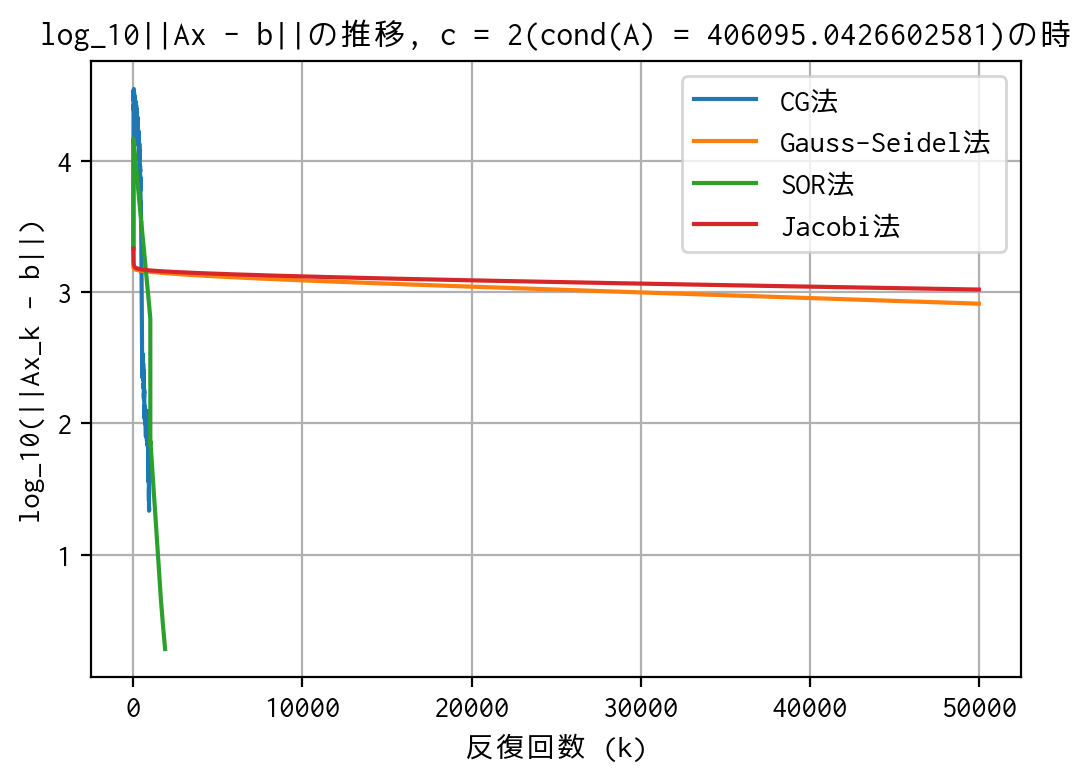

In [9]:
plot_errors_by_log(2)

(ⅱ) c = 20 の時

CG法はk=7で収束しました。
Gauss-Seidel法はk=7で収束しました。
SOR法はk=7で収束しました。
Jacobi法はk=9で収束しました。


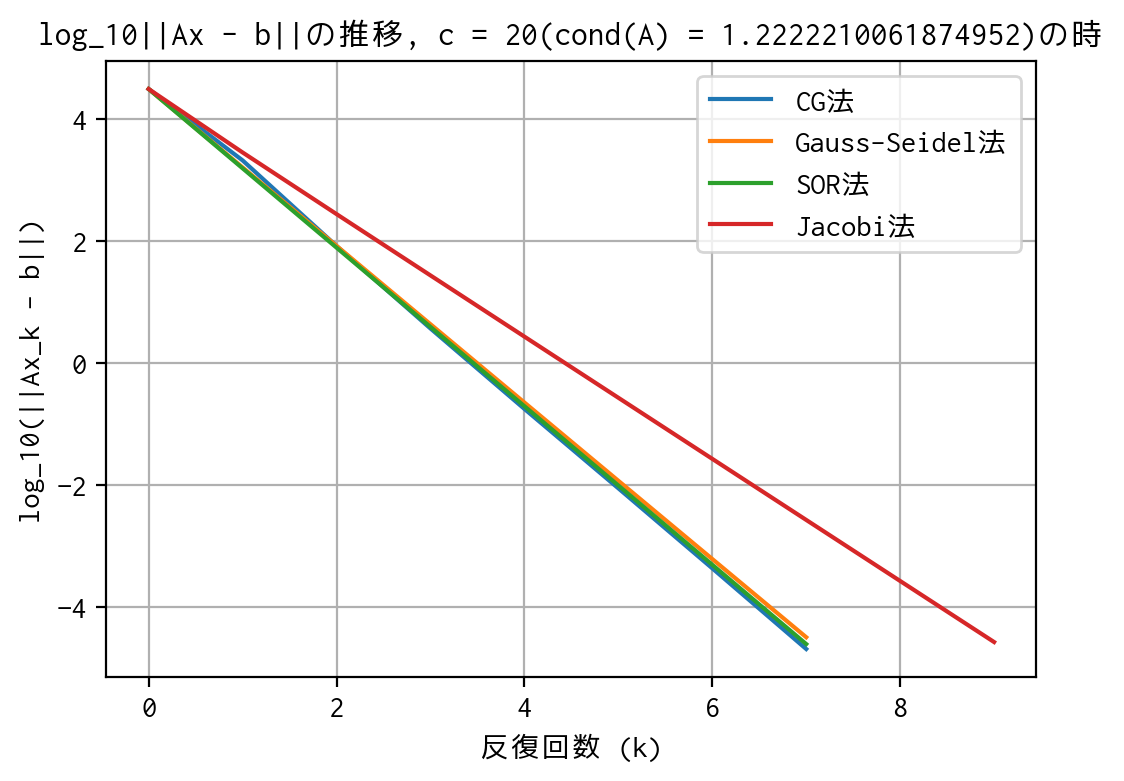

In [10]:
plot_errors_by_log(20)

## (2) 考察

#### c = 2 と c = 20 の比較

In [11]:
print("c = 2の時の条件数: ", np.linalg.cond(tridiagonal_matrix(2)))
print("c = 20の時の条件数: ", np.linalg.cond(tridiagonal_matrix(20)))

c = 2の時の条件数:  406095.0426602581
c = 20の時の条件数:  1.2222210061874952


c =20 ではCOR法以外では急速に||Ax - b||が0に近づき、許容誤差を下回るまでに10回程度の反復で十分だったのに対し、c = 2で||Ax - b||が5000回の反復で0に収束していっているように見えるのは、CG法とSOR法だけであり、そのCG法やSOR法でも、誤差は10^-6程度で固まって、許容誤差を下回ることはなかった。

上のように、c = 2 と c = 20 とで条件数が約100万倍異なるが、この現象はこの条件数の差が大きく影響を及ぼしていると考えられる。

#### 各手法の比較

CG法以外の定常反復法ではほぼ一様に||Ax-b||の値が0に近づいているように見える。

一方、CG法では、反復回数が小さい時に誤差が急激に大きくなるが、c = 2でもc = 20でも、反復をある程度繰り返したあたりから急速に収束に向かった。

また、定常反復法において、行列のスペクトル半径を観察する

In [12]:
def max_eigenvalue(A):
    return np.sort(np.abs(np.linalg.eig(A)[0]))[-1]

def spectral_radiuses(c):
    A = tridiagonal_matrix(c)

    # GS
    LD_inv = np.linalg.inv(np.tril(A))
    U = np.triu(A, 1)
    print("Gauss-Seidel法のスペクトル半径は{}".format(max_eigenvalue(-1 * LD_inv @ U)))

    # SOR
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L+U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    w = 2/(1+np.sqrt(1-rho_Mj**2))
    T = np.linalg.inv(D+w*L)
    print("SOR法のスペクトル半径は{}".format(max_eigenvalue(np.dot(T, -w*U+(1-w)*D))))
    
    # jacobi
    D = np.diag(np.diag(A))
    LU = A - D
    D_inv = np.linalg.inv(D)
    print("Jacobi法のスペクトル半径は{}".format(max_eigenvalue(-1 * D_inv @ LU)))


c = 2

In [13]:
spectral_radiuses(2)

Gauss-Seidel法のスペクトル半径は0.9999901501375795
SOR法のスペクトル半径は0.9937427399987759
Jacobi法のスペクトル半径は0.9999950750566646


c = 20

In [14]:
spectral_radiuses(20)

Gauss-Seidel法のスペクトル半径は0.02009607880562554
SOR法のスペクトル半径は0.007596793131780399
Jacobi法のスペクトル半径は0.09999950750566644


いずれもスペクトル半径は1を下回っているので、収束条件を満たしている。